<a href="https://colab.research.google.com/github/seongcho1/mnetest/blob/main/eeg_motor_imagery_004_Identify_EEG_Electrodes_Bridged_by_too_much_Gel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Identify EEG Electrodes Bridged by too much Gel
Research-grade EEG often uses a gel based system, and when too much gel is applied the gel conducting signal from the scalp to the electrode for one electrode connects with the gel conducting signal from another electrode “bridging” the two signals. This is undesirable because the signals from the two (or more) electrodes are not as independent as they would otherwise be; they are very similar to each other introducting additional spatial smearing. An algorithm has been developed to detect electrode bridging [1], which has been implemented in EEGLAB [2]. Unfortunately, there is not a lot to be done about electrode brigding once the data has been collected as far as preprocessing other than interpolating bridged channels. Therefore, our recommendation is to check for electrode bridging early in data collection and address the problem. Or, if the data has already been collected, quantify the extent of the bridging so as not to introduce bias into the data from this effect and exclude subjects with bridging that might effect the outcome of a study. Preventing electrode bridging is ideal but awareness of the problem at least will mitigate its potential as a confound to a study. This tutorial follows https://psychophysiology.cpmc.columbia.edu/software/eBridge/tutorial.html.

https://mne.tools/stable/auto_examples/preprocessing/eeg_bridging.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 44.4 MB/s eta 0:00:00


In [3]:
import mne

print(__doc__)

Automatically created module for IPython interactive environment


#Compute Electrical Distance Metric
First, let’s compute electrical distance metrics for a group of example subjects from the EEGBCI dataset in order to estimate electrode bridging. The electrical distance is just the variance of signals subtracted pairwise. Channels with activity that mirror another channel nearly exactly will have very low electrical distance. By inspecting the distribution of electrical distances, we can look for pairwise distances that are consistently near zero which are indicative of bridging.

##Note

It is likely to be sufficient to run this algorithm on a small portion (~3 minutes is probably plenty) of the data but that gel might settle over the course of a study causing more bridging so using the last segment of the data will give the most conservative estimate.

In [10]:
montage = mne.channels.make_standard_montage('standard_1005')
ed_data = dict()  # electrical distance/bridging data
raw_data = dict()  # store infos for electrode positions
for sub in range(1, 11):
    print(f'Computing electrode bridges for subject {sub}')
    raw_fname = mne.datasets.eegbci.load_data(subject=sub, runs=(6,))[0]
    raw = mne.io.read_raw(raw_fname, preload=True, verbose=False)
    mne.datasets.eegbci.standardize(raw)  # set channel names
    raw.set_montage(montage, verbose=False)
    raw_data[sub] = raw
    ed_data[sub] = mne.preprocessing.compute_bridged_electrodes(raw)

Computing electrode bridges for subject 1


Local minimum 1.1959919512423807e-11 found


Computing electrode bridges for subject 2


Local minimum 6.5455690741607775 found
Bridge detected between Oz and Iz


Computing electrode bridges for subject 3


Local minimum 1.1959919512423807e-11 found


Computing electrode bridges for subject 4


Local minimum 3.516592176094274 found
Bridge detected between FCz and FC2
Bridge detected between FC4 and FC6
Bridge detected between F2 and F4


Computing electrode bridges for subject 5


Local minimum 1.2297035912376655e-11 found


Computing electrode bridges for subject 6


Local minimum 4.306730287380598 found
Bridge detected between FC3 and FC1
Bridge detected between FC2 and FC4
Bridge detected between CP3 and CP1
Bridge detected between AF7 and AF3
Bridge detected between AF4 and AF8
Bridge detected between F5 and F3
Bridge detected between F5 and F1
Bridge detected between F5 and Fz
Bridge detected between F3 and F1
Bridge detected between F3 and Fz
Bridge detected between F1 and Fz
Bridge detected between F2 and F4
Bridge detected between FT8 and T8
Bridge detected between FT8 and TP8
Bridge detected between FT8 and P8
Bridge detected between T8 and TP8
Bridge detected between T8 and P8
Bridge detected between TP8 and P8
Bridge detected between P7 and P5
Bridge detected between P7 and PO7
Bridge detected between P5 and PO7
Bridge detected between P3 and P1
Bridge detected between P4 and P6
Bridge detected between PO3 and O1
Bridge detected between PO4 and PO8


Computing electrode bridges for subject 7


Local minimum 14.81578267167382 found
Bridge detected between FCz and FC2
Bridge detected between FCz and FC4
Bridge detected between FC2 and FC4
Bridge detected between C1 and Cz
Bridge detected between C2 and C4
Bridge detected between CP2 and CP4
Bridge detected between AF4 and AF8
Bridge detected between F3 and F1
Bridge detected between F3 and Fz
Bridge detected between F3 and F2
Bridge detected between F3 and F4
Bridge detected between F3 and F6
Bridge detected between F1 and Fz
Bridge detected between F1 and F2
Bridge detected between F1 and F4
Bridge detected between F1 and F6
Bridge detected between Fz and F2
Bridge detected between Fz and F4
Bridge detected between Fz and F6
Bridge detected between F2 and F4
Bridge detected between F2 and F6
Bridge detected between F4 and F6
Bridge detected between Pz and P2
Bridge detected between PO4 and PO8


Computing electrode bridges for subject 8


Local minimum 11.532777458055492 found
Bridge detected between FCz and FC2
Bridge detected between FCz and FC4
Bridge detected between FC2 and FC4
Bridge detected between F5 and F3
Bridge detected between F5 and F1
Bridge detected between F5 and Fz
Bridge detected between F3 and F1
Bridge detected between F3 and Fz
Bridge detected between F1 and Fz
Bridge detected between F2 and F4
Bridge detected between F2 and F6
Bridge detected between F4 and F6
Bridge detected between Pz and P2
Bridge detected between Pz and P4
Bridge detected between P2 and P4


Computing electrode bridges for subject 9


Computing electrode bridges for subject 10


# Examine an Electrical Distance Matrix
Before we look at the electrical distance distributions across subjects, let’s look at the distance matrix for one subject and try and understand how the algorithm works. We’ll use subject 6 as it is a good example of bridging. In the zoomed out color scale version on the right, we can see that there is a distribution of electrical distances that are specific to that subject’s head physiology/geometry and brain activity during the recording. On the right, when we clip the color range to zoom in, we can see several electrical distance outliers that are near zero; these indicate bridging.

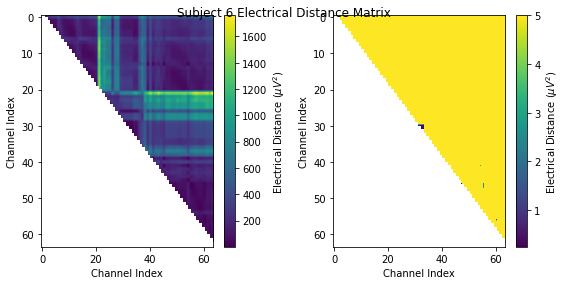

In [11]:
bridged_idx, ed_matrix = ed_data[6]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Subject 6 Electrical Distance Matrix')

# take median across epochs, only use upper triangular, lower is NaNs
ed_plot = np.zeros(ed_matrix.shape[1:]) * np.nan
triu_idx = np.triu_indices(ed_plot.shape[0], 1)
for idx0, idx1 in np.array(triu_idx).T:
    ed_plot[idx0, idx1] = np.nanmedian(ed_matrix[:, idx0, idx1])

# plot full distribution color range
im1 = ax1.imshow(ed_plot, aspect='auto')
cax1 = fig.colorbar(im1, ax=ax1)
cax1.set_label(r'Electrical Distance ($\mu$$V^2$)')

# plot zoomed in colors
im2 = ax2.imshow(ed_plot, aspect='auto', vmax=5)
cax2 = fig.colorbar(im2, ax=ax2)
cax2.set_label(r'Electrical Distance ($\mu$$V^2$)')
for ax in (ax1, ax2):
    ax.set_xlabel('Channel Index')
    ax.set_ylabel('Channel Index')

fig.tight_layout()

# Examine the Distribution of Electrical Distances
Now let’s plot a histogram of the electrical distance matrix. Note that the electrical distance matrix from the previous plot is upper triangular but does not include the diagonal. This means that the pairwise electrical distances are not computed between the same channel (which makes sense as the differences between a channel and itself would just be zero). The initial peak near zero therefore represents pairs of different channels that are nearly identical which is indicative of bridging. EEG recordings without bridged electrodes do not have a peak near zero.

Text(0, 0.5, 'Count (channel pairs for all epochs)')

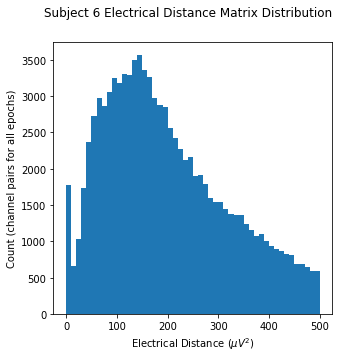

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.suptitle('Subject 6 Electrical Distance Matrix Distribution')
ax.hist(ed_matrix[~np.isnan(ed_matrix)], bins=np.linspace(0, 500, 51))
ax.set_xlabel(r'Electrical Distance ($\mu$$V^2$)')
ax.set_ylabel('Count (channel pairs for all epochs)')

# Plot Electrical Distances on a Topomap
Now, let’s look at the topography of the electrical distance matrix and see where our bridged channels are and check that their spatial arrangement makes sense. Here, we are looking at the minimum electrical distance for each channel and taking the median across all epochs (the raw data is epoched into 2 second non-overlapping intervals). This example is of the subject from the EEGBCI dataset with the most bridged channels so there are many light areas and red lines. They are generally grouped together and are biased toward horizontal connections (this may be because the EEG experimenter usually stands to the side and may have inserted the gel syringe tip in too far).

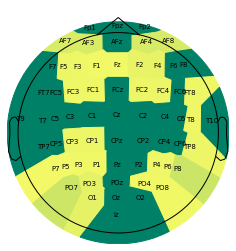

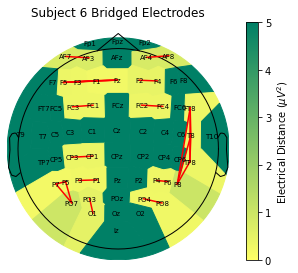

In [13]:
mne.viz.plot_bridged_electrodes(
    raw_data[6].info, bridged_idx, ed_matrix,
    title='Subject 6 Bridged Electrodes', topomap_args=dict(vlim=(None, 5)))

# Plot the Raw Voltage Time Series for Bridged Electrodes
Finally, let’s do a sanity check and make sure that the bridged electrodes are indeed implausibly similar. We’ll plot two bridged electrode pairs: F2-F4 and FC2-FC4, for subject 6 where they are bridged and subject 1 where they are not. As we can see, the pairs are nearly identical for subject 6 confirming that they are likely bridged. Interestingly, even though the two pairs are adjacent to each other, there are two distinctive pairs, meaning that it is unlikely that all four of these electrodes are bridged.

Creating RawArray with float64 data, n_channels=1, n_times=19680
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=19680
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


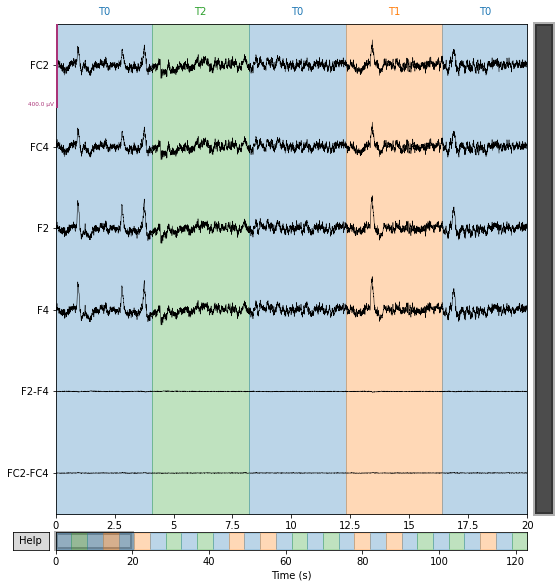

Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


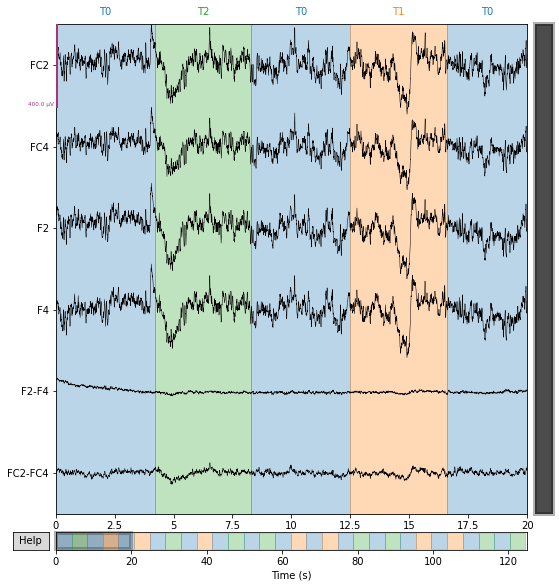

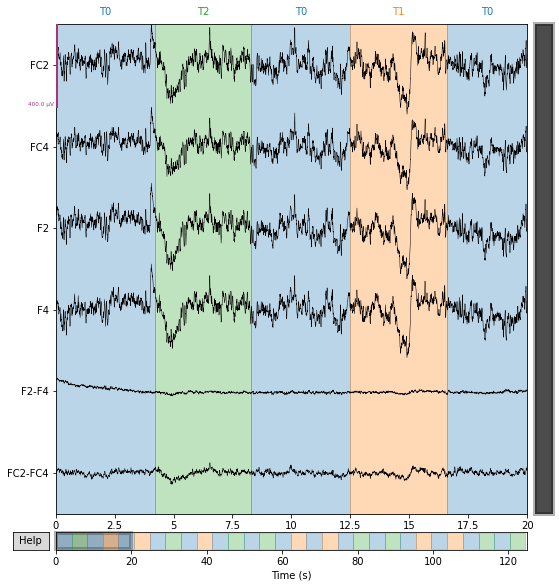

In [14]:
raw = raw_data[6].copy().pick_channels(['F2', 'F4', 'FC2', 'FC4'])
raw.add_channels([mne.io.RawArray(
    raw.get_data(ch1) - raw.get_data(ch2),
    mne.create_info([f'{ch1}-{ch2}'], raw.info['sfreq'], 'eeg'),
    raw.first_samp) for ch1, ch2 in [('F2', 'F4'), ('FC2', 'FC4')]])
raw.plot(duration=20, scalings=dict(eeg=2e-4))

raw = raw_data[1].copy().pick_channels(['F2', 'F4', 'FC2', 'FC4'])
raw.add_channels([mne.io.RawArray(
    raw.get_data(ch1) - raw.get_data(ch2),
    mne.create_info([f'{ch1}-{ch2}'], raw.info['sfreq'], 'eeg'),
    raw.first_samp) for ch1, ch2 in [('F2', 'F4'), ('FC2', 'FC4')]])
raw.plot(duration=20, scalings=dict(eeg=2e-4))

# Compare Bridging Across Subjects in the EEGBCI Dataset
Now, let’s look at the histograms of electrical distances for the whole EEGBCI dataset. As we can see in the zoomed in insert on the right, for subjects 6, 7 and 8 (and to a lesser extent 2 and 4), there is a different shape of the distribution of electrical distances around 0 
 than for the other subjects. These subjects’ distributions have a peak around 0 
 distance and a trough around 5 
 which is indicative of electrode bridging. The rest of the subjects’ distributions increase monotonically, indicating normal spatial separation of sources. The large discrepancy in shapes of distributions is likely driven primarily by artifacts such as blinks which are an order of magnitude larger than neural data since this data has not been preprocessed but likely reflect neural or at least anatomical differences as well (i.e. the distance from the sensors to the brain).

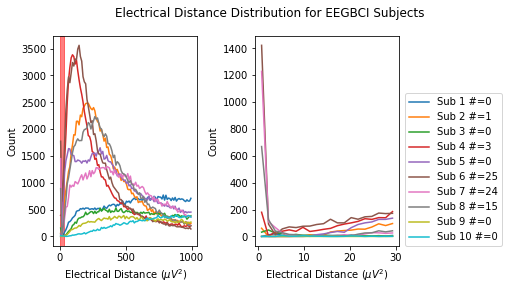

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Electrical Distance Distribution for EEGBCI Subjects')
for ax in (ax1, ax2):
    ax.set_ylabel('Count')
    ax.set_xlabel(r'Electrical Distance ($\mu$$V^2$)')

for sub, (bridged_idx, ed_matrix) in ed_data.items():
    # ed_matrix is upper triangular so exclude bottom half of NaNs
    hist, edges = np.histogram(ed_matrix[~np.isnan(ed_matrix)].flatten(),
                               bins=np.linspace(0, 1000, 101))
    centers = (edges[1:] + edges[:-1]) / 2
    ax1.plot(centers, hist)
    hist, edges = np.histogram(ed_matrix[~np.isnan(ed_matrix)].flatten(),
                               bins=np.linspace(0, 30, 21))
    centers = (edges[1:] + edges[:-1]) / 2
    ax2.plot(centers, hist, label=f'Sub {sub} #={len(bridged_idx)}')

ax1.axvspan(0, 30, color='r', alpha=0.5)
ax2.legend(loc=(1.04, 0))
fig.subplots_adjust(right=0.725, bottom=0.15, wspace=0.4)

For the group of subjects, let’s look at their electrical distances and bridging. Especially since this is the same task, the lack of low electrical distances in many of the subjects is compelling evidence that the low electrical distance is caused by bridging and that it is avoidable given more judicious application of gel or other conductive electrolyte solution.

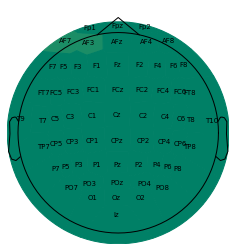

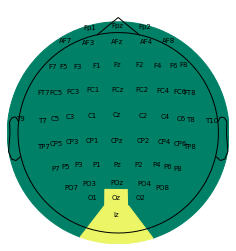

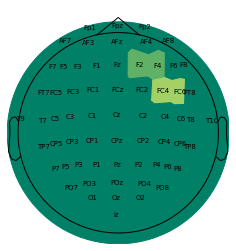

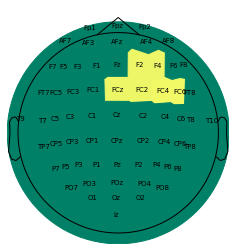

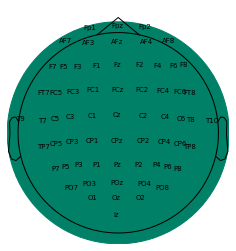

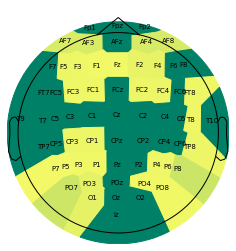

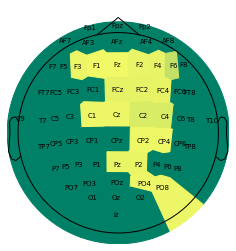

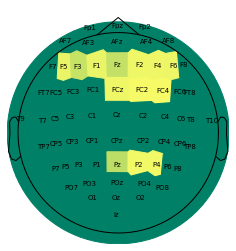

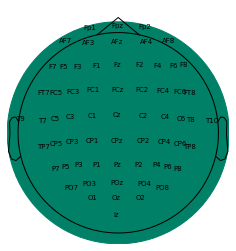

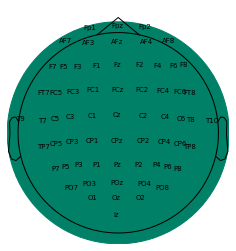

In [16]:
for sub, (bridged_idx, ed_matrix) in ed_data.items():
    mne.viz.plot_bridged_electrodes(
        raw_data[sub].info, bridged_idx, ed_matrix,
        title=f'Subject {sub} Bridged Electrodes',
        topomap_args=dict(vlim=(None, 5)))

For subjects with many bridged channels like Subject 6 shown in the example above, it is advisable to exclude the subject. This because EEG recording montage will not be comparable with the other subjects. And, if we tried to interpole, the interpolation would depend on other channels which are also bridged in that case. However, for subjects with only a few bridged channels, those channels can be interpolated. Since the bridged data is still biological (i.e. it is recording the subject’s brain), it’s just spatially smeared, we can use mne.preprocessing.interpolate_bridged_electrodes() to make a virtual channel midway between the two bridged channels to aid in interpolation.

In [17]:
# use subject 2, only one bridged electrode pair
bridged_idx = ed_data[2][0]
raw = mne.preprocessing.interpolate_bridged_electrodes(
    raw_data[2].copy(), bridged_idx=bridged_idx)

Creating RawArray with float64 data, n_channels=1, n_times=19680
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Interpolating bad channels
    Automatic origin fit: head of radius 95.5 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 2 sensors


Let’s make sure that our virtual channel aided the interpolation. We can do this by simulating a bridge to make sure that we recover the original data better with the virtual channel method. If we make two channels nearly the same to simulate a bridged electrode but save the original data, we can compare the two interpolation methods. As we can see, the virtual channel recovers the original data more slightly closely. However, as shown in the plots, there is still residual signal for both methods implying that it is there is still a loss of data compared to unbridged channels.

Creating RawArray with float64 data, n_channels=2, n_times=19680
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=19680
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Interpolating bad channels
    Automatic origin fit: head of radius 95.5 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 2 sensors
Interpolating bad channels
    Automatic origin fit: head of radius 95.5 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
Variance of residual (interpolated data - original data)

With adding virtual channel:                         5.058963321666229e-10
Compared to interpolation only using other channels: 5.547884604545633e-10
Creating RawArray with float64 data, n_channels=4, n_times=19680
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=19680
    Range : 0 ... 19679 =      

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


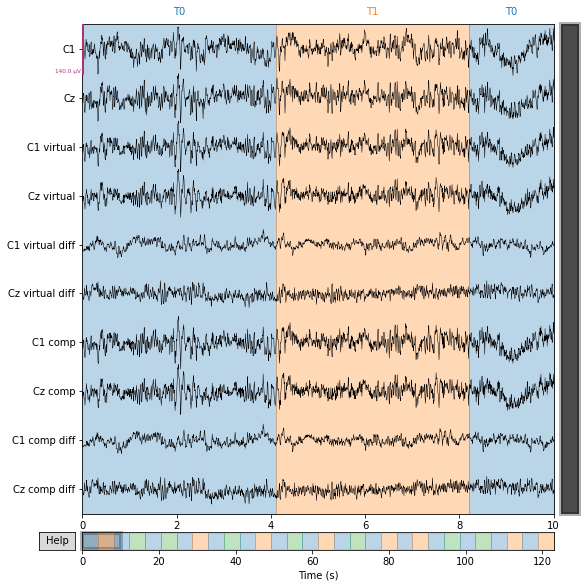

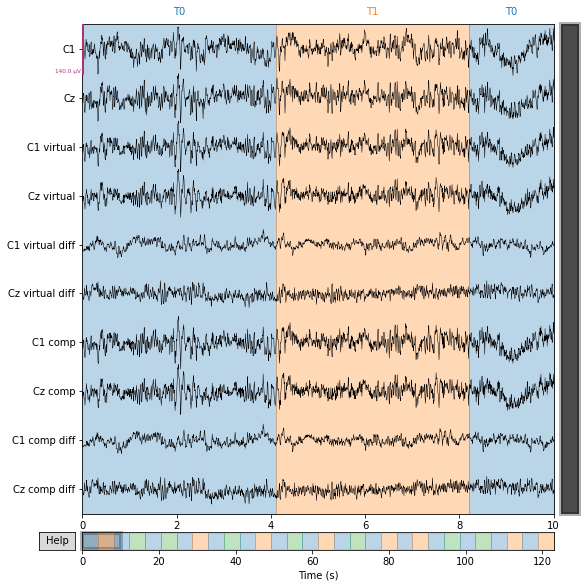

In [18]:
raw = raw_data[2].copy()

# pick two channels to simulate a bridge
idx0, idx1 = 9, 10
ch0, ch1 = raw.ch_names[idx0], raw.ch_names[idx1]
bridged_idx_simulated = [(idx0, idx1)]
# get the original data to compare to
data_orig = raw_data[2].get_data(picks=(idx0, idx1))

# simulate a bridge between the two channels by taking their mean and adding
# some noise
rng = np.random.default_rng(11)  # seed for reproducibility
raw_sim = raw.copy()  # raw with simulated electrode bridge
# remove channels with original data
raw_sim = raw_sim.drop_channels([ch0, ch1])
bridged_data = np.tile(np.mean(data_orig, axis=0), (2, 1))  # copy mean
# add separate noise for each channel
bridged_data[0] += 1e-7 * rng.normal(size=raw.times.size)
bridged_data[1] += 1e-7 * rng.normal(size=raw.times.size)
# add back simulated data
raw_sim = raw_sim.add_channels([mne.io.RawArray(
    bridged_data, mne.create_info([ch0, ch1], raw.info['sfreq'], 'eeg'),
    raw.first_samp)])
raw_sim.set_montage(montage)  # add back channel positions

# use virtual channel method
raw_virtual = mne.preprocessing.interpolate_bridged_electrodes(
    raw_sim.copy(), bridged_idx=bridged_idx_simulated)
data_virtual = raw_virtual.get_data(picks=(idx0, idx1))

# set bads to be bridged electrodes to interpolate without a virtual channel
raw_comp = raw_sim.copy()
raw_comp.info['bads'] = [raw_sim.ch_names[idx0], raw_sim.ch_names[idx1]]
raw_comp.interpolate_bads()
data_comp = raw_comp.get_data(picks=(idx0, idx1))

# compute variance of residuals
print('Variance of residual (interpolated data - original data)\n\n'
      'With adding virtual channel:                         {}\n'
      'Compared to interpolation only using other channels: {}'
      ''.format(np.mean(np.var(data_virtual - data_orig, axis=1)),
                np.mean(np.var(data_comp - data_orig, axis=1))))

# plot results
raw = raw.pick_channels([ch0, ch1])
raw = raw.add_channels([mne.io.RawArray(
    np.concatenate([data_virtual, data_virtual - data_orig]),
    mne.create_info([f'{ch0} virtual', f'{ch1} virtual',
                     f'{ch0} virtual diff', f'{ch1} virtual diff'],
                    raw.info['sfreq'], 'eeg'), raw.first_samp)])
raw = raw.add_channels([mne.io.RawArray(
    np.concatenate([data_comp, data_comp - data_orig]),
    mne.create_info([f'{ch0} comp', f'{ch1} comp',
                     f'{ch0} comp diff', f'{ch1} comp diff'],
                    raw.info['sfreq'], 'eeg'), raw.first_samp)])
raw.plot(scalings=dict(eeg=7e-5))

# The Relationship Between Bridging and Impedances
Electrode bridging is often brought about by inserting more gel in order to bring impendances down. Thus it can be helpful to compare bridging to impedances in the quest to be an ideal EEG technician! Low impedances lead to less noisy data and EEG without bridging is more spatially precise. Brain Imaging Data Structure (BIDS) recommends that impedances be stored in an EEG dataset in the electrodes.tsv file. Since the impedances are not stored for this dataset, we will fake them to demonstrate how they would be plotted. Here, the impedances are plotted as is typical at the end of a setup; most channels are good but there are a few that need to have their impedance lowered. The impedances should ideally all be less than 25 KOhm before starting an experiment when using active systems and less than 5 KOhm when using a passive system.

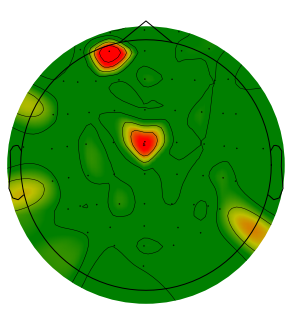

In [19]:
rng = np.random.default_rng(11)  # seed for reproducibility
raw = raw_data[1]
# typically impedances < 25 kOhm are acceptable for active systems and
# impedances < 5 kOhm are desirable for a passive system
impedances = rng.random((len(raw.ch_names,))) * 30
impedances[10] = 80  # set a few bad impendances
impedances[25] = 99
cmap = LinearSegmentedColormap.from_list(name='impedance_cmap',
                                         colors=['g', 'y', 'r'], N=256)
fig, ax = plt.subplots(figsize=(5, 5))
im, cn = mne.viz.plot_topomap(impedances, raw.info, axes=ax,
                              cmap=cmap, vlim=(25, 75))
ax.set_title('Electrode Impendances')
cax = fig.colorbar(im, ax=ax)
cax.set_label(r'Impedance (k$\Omega$)')

# Summary
In this example, we have shown a dataset where electrical bridging occurred during the EEG setup for several subjects. Hopefully this is convincing as to the importance of proper technique as well as checking your work to learn and improve as an EEG experimenter, and hopefully this tool will help us all collect better EEG data in the future.

# References
[1]
C. E. Tenke and J. Kayser. A convenient method for detecting electrolyte bridges in multichannel electroencephalogram and event-related potential recordings. Clinical Neurophysiology: Official Journal of the International Federation of Clinical Neurophysiology, 112(3):545–550, March 2001. doi:10.1016/s1388-2457(00)00553-8.

[2]
Arnaud Delorme and Scott Makeig. EEGLAB: an open source toolbox for analysis of single-trial EEG dynamics including independent component analysis. Journal of Neuroscience Methods, 134(1):9–21, March 2004. doi:10.1016/j.jneumeth.2003.10.009.